In [1]:
# 导入必要的库
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchsummary import summary

In [2]:
# 设置超参数
BATCH_SIZE = 128
NUM_CLASSES = 10    
LR = 0.1 # for SGD optimizer
# LR = 3e-4 # for Adam optimizer
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
EPOCHS = 200      
# 随机种子,本次不用
# SEED = 42

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f'runs/CIFAR10_exp1_{timestamp}')


In [3]:
MEAN = [0.4914, 0.4822, 0.4465]
STD  = [0.2470, 0.2435, 0.2616]

# CIFAR-10类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # 以0.5的概率水平翻转图像，增加数据多样性
    transforms.RandomCrop(32, padding=4), # 32x32的图像，填充4个像素后再裁剪回32x32 模拟图像小范围位移，提高平移不变性

    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), 
    transforms.RandomRotation(degrees=15), 
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 

    transforms.ToTensor(), 
    transforms.Normalize(MEAN, STD), 
    
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random') 
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = datasets.CIFAR10(root='./datasets', train=True, transform=train_transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16)

test_dataset = datasets.CIFAR10(root='./datasets', train=False, transform=test_transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=16)

In [4]:
# 定义残差块 较低深度的ResNet使用BasicBlock
class BasicBlock(nn.Module):
    expansion = 1 

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [5]:
# 2.定义ResNet-18模型
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # 3x32x32 → 64x32x32
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # 64x32x32 → 128x16x16
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2) # 128x16x16 → 256x8x8
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2) # 256x8x8 → 512x4x4
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x))) # 3×32×32 → 64×32×32
        x = self.layer1(x) # 64×32×32 → 64×32×32
        x = self.layer2(x) # 64×32×32 → 128×16×16
        x = self.layer3(x) # 128×16×16 → 256×8×8
        x = self.layer4(x) # 256×8×8 → 512×4×4
        x = F.avg_pool2d(x, 4) 
        x = x.view(x.size(0), -1) 
        x = self.linear(x)
        return x
    
model = ResNet18(BasicBlock, [2, 2, 2, 2], NUM_CLASSES).to(DEVICE) # 每层的残差块数量（2+2+2+2=8个块 × 2层/块 = 16个卷积层 + 1个初始卷积 = 17层）

# 输入尺寸为 (C, H, W) = (3, 32, 32)
# 输出参数量
print("\n模型结构概览：")
#summary(model, input_size=(3, 32, 32))


模型结构概览：


In [6]:
#3.定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# adam
# optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=WEIGHT_DECAY)

# 学习率调度器 200轮 学习率衰减
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70, 120, 160], gamma=0.1)

# 余弦退火学习率调度器 
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS) 


In [7]:
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    return train_loss, train_acc

In [8]:
# 5.测试模型
def test(epoch):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    return test_loss, test_acc

In [9]:
# 6.绘图
def plot(train_loss, test_accuracy):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracy, 'r', label='Test Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

Epoch 1/200: Train Loss: 1.9127, Train Acc: 29.96%, Test Loss: 1.6895, Test Acc: 38.12%
New best model saved with accuracy: 38.12%
Epoch 2/200: Train Loss: 1.5026, Train Acc: 44.87%, Test Loss: 1.3259, Test Acc: 51.20%
New best model saved with accuracy: 51.20%
Epoch 3/200: Train Loss: 1.2828, Train Acc: 53.94%, Test Loss: 1.1300, Test Acc: 58.11%
New best model saved with accuracy: 58.11%
Epoch 4/200: Train Loss: 1.1098, Train Acc: 60.45%, Test Loss: 1.0432, Test Acc: 64.08%
New best model saved with accuracy: 64.08%
Epoch 5/200: Train Loss: 0.9786, Train Acc: 65.22%, Test Loss: 0.8677, Test Acc: 69.84%
New best model saved with accuracy: 69.84%
Epoch 6/200: Train Loss: 0.8668, Train Acc: 69.65%, Test Loss: 0.9028, Test Acc: 69.03%
Epoch 7/200: Train Loss: 0.7777, Train Acc: 72.84%, Test Loss: 0.7174, Test Acc: 75.80%
New best model saved with accuracy: 75.80%
Epoch 8/200: Train Loss: 0.7307, Train Acc: 74.67%, Test Loss: 0.8111, Test Acc: 73.42%
Epoch 9/200: Train Loss: 0.6940, Train

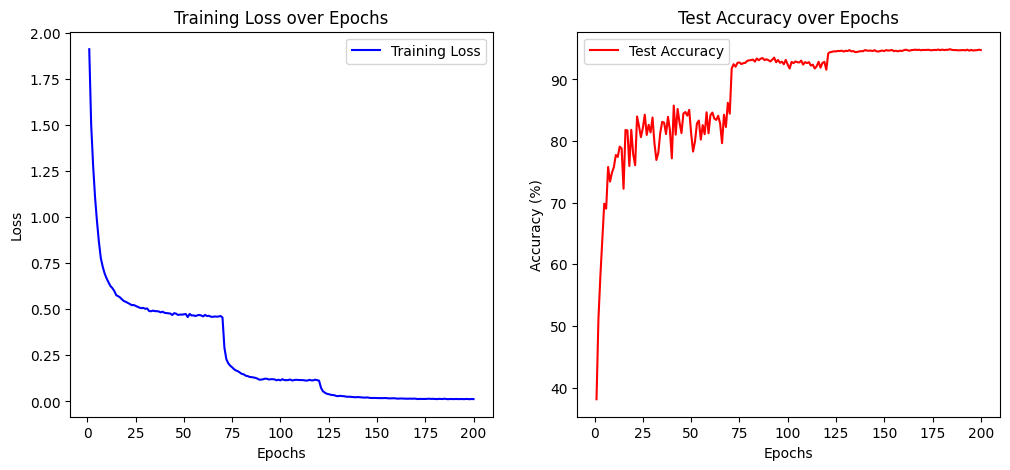

Training completed! Best accuracy: 94.90%


In [10]:
# 7.训练模型
if __name__ == '__main__':
    os.makedirs('model', exist_ok=True)
    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(EPOCHS):  
        train_loss, train_acc = train(epoch)
        test_loss, test_acc = test(epoch)
        scheduler.step() # 更新学习率
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        writer.add_scalars('Accuracy', {
            'Train': train_acc,
            'Test': test_acc
        }, epoch)
        
        writer.add_scalars('Loss', {
            'Train': train_loss,
            'Test': test_loss
        }, epoch)
        
        print(f'Epoch {epoch+1}/{EPOCHS}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': test_acc
            }, f'model/best_modelA3.pth')
            print(f'New best model saved with accuracy: {test_acc:.2f}%')

    writer.close()
    plot(train_losses, test_accuracies)
    print(f'Training completed! Best accuracy: {best_accuracy:.2f}%')

In [11]:
# 评估模块，加载最佳模型并生成分类报告和混淆矩阵
# 评估
# 7.1 计算每个类别的准确率
def test_per_class(model, test_loader):
    model.eval()
    class_correct = list(0. for _ in range(10))
    class_total = list(0. for _ in range(10))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(images)):
                label = labels[i].item()  # 转换为 Python 整数
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
    for i in range(10):
        if class_total[i] > 0:
            print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i]/class_total[i]:2.0f}%')
        else:
            print(f'Accuracy of {classes[i]:5s} : N/A')


# 7.2 获取预测结果用于混淆矩阵和分类报告
def get_predictions(model, test_loader):
    model.eval()
    y_trues = []
    y_preds = []
    y_scores = []  # 用于ROC曲线的概率分数
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(DEVICE)
            logits = model(x)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = logits.argmax(dim=1).cpu()
            
            y_scores.append(probs)
            y_preds.extend(preds.numpy())
            y_trues.extend(y.numpy())
    
    y_scores = np.vstack(y_scores)
    return y_trues, y_preds, y_scores


# 7.3 生成混淆矩阵与分类报告
def evaluate_classification(model, test_loader):
    # 获取预测结果
    y_trues, y_preds, y_scores = get_predictions(model, test_loader)
    
    # 分类报告
    print("Classification Report:")
    print(classification_report(y_trues, y_preds, target_names=classes))
    
    # 混淆矩阵
    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    return y_trues, y_preds, y_scores


# 7.4 绘制ROC曲线
'''
采用 One-vs-Rest 方法，对每个类分别绘制 ROC 曲线。
AUC 越高，说明该类的分类能力越强。
'''
def plot_roc_curve(y_trues, y_scores, classes):
    n_classes = len(classes)
    y_trues_bin = label_binarize(y_trues, classes=list(range(n_classes)))
    
    # 针对每一类画ROC
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_trues_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (one-vs-rest)')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()


=== 每个类别的准确率 ===
Accuracy of plane : 95%
Accuracy of car   : 98%
Accuracy of bird  : 94%
Accuracy of cat   : 89%
Accuracy of deer  : 96%
Accuracy of dog   : 91%
Accuracy of frog  : 97%
Accuracy of horse : 96%
Accuracy of ship  : 97%
Accuracy of truck : 96%

=== 分类报告和混淆矩阵 ===
Classification Report:
              precision    recall  f1-score   support

       plane       0.95      0.95      0.95      1000
         car       0.97      0.98      0.97      1000
        bird       0.93      0.94      0.94      1000
         cat       0.88      0.89      0.89      1000
        deer       0.95      0.96      0.95      1000
         dog       0.91      0.91      0.91      1000
        frog       0.97      0.97      0.97      1000
       horse       0.99      0.96      0.97      1000
        ship       0.96      0.97      0.97      1000
       truck       0.97      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10

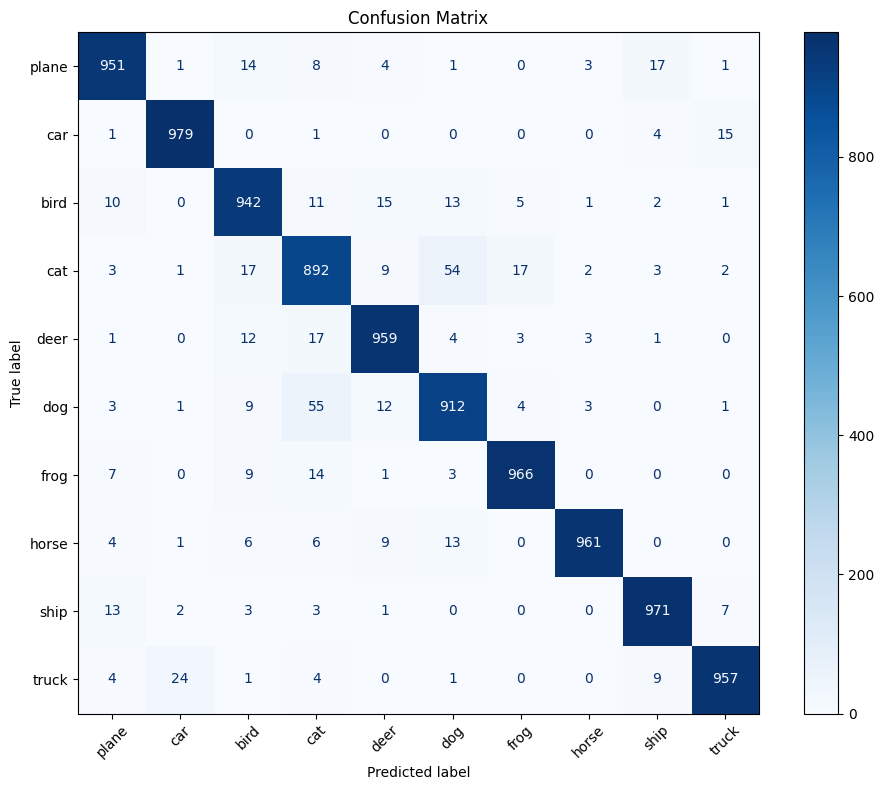


=== ROC曲线 ===


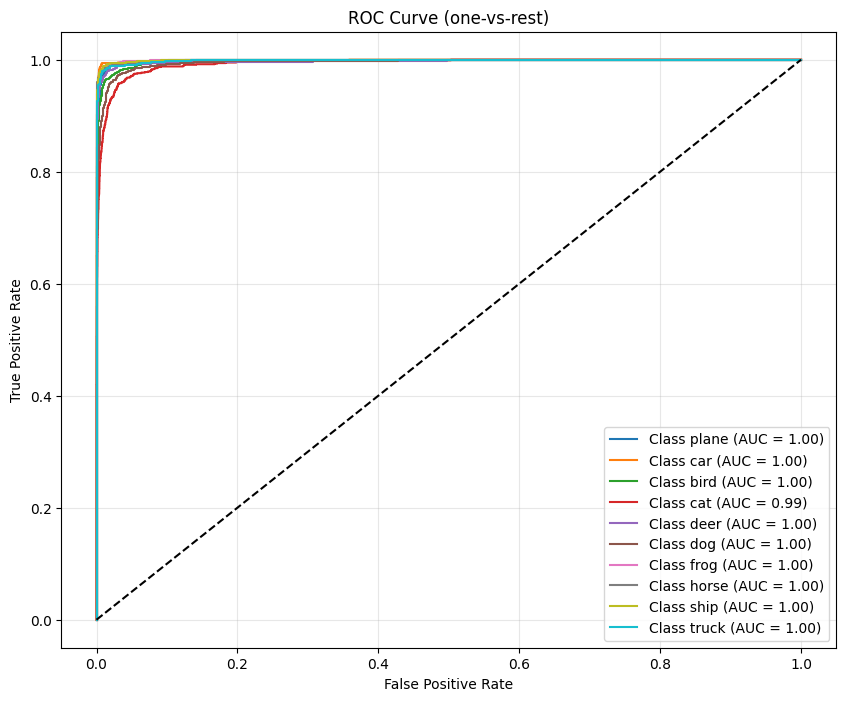

In [12]:
# 使用新增函数进行评估
if __name__ == '__main__':
    # 加载最佳模型
    if os.path.exists('model/best_modelA3.pth'):
        checkpoint = torch.load('model/best_modelA3.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(DEVICE)
        
        print("\n=== 每个类别的准确率 ===")
        test_per_class(model, test_loader)
        
        print("\n=== 分类报告和混淆矩阵 ===")
        y_trues, y_preds, y_scores = evaluate_classification(model, test_loader)
        
        print("\n=== ROC曲线 ===")
        plot_roc_curve(y_trues, y_scores, classes)
    else:
        print("未找到最佳模型文件 'model/best_model.pth'，请先运行训练。")